# Important Libararies

In [113]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
!pip install minisom
from minisom import MiniSom
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.utils.multiclass import unique_labels

# Important Functions

### Plot T-SNE

In [2]:
def plot_tsne(data, target, title):
    # Separate features and target variable
    X = data.drop(columns=[target, 'Id'])
    y = data[target]

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Create a scatter plot
    plt.figure(figsize=(10, 5))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='rainbow', marker='o', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


### Plot Confusion Matrix

In [3]:
def plot_confusion_matrix(cm, model_name):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(7), ['1', '2', '3', '4', '5', '6', '7'])
    plt.yticks(np.arange(7), ['1', '2', '3', '4', '5', '6', '7'])

    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black')

    plt.show()

### Plot Accuracies

In [4]:
def plot_accuracies(accuracies):
    plt.figure(figsize=(10, 5))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Baseline Performance - Accuracy of Different ML Models')
    plt.show()

### Tabulate

In [5]:
def tabulate_accuracies(accuracies):
    table = [["Model", "Accuracy"]]
    for model_name, acc in accuracies.items():
        table.append([model_name, acc])

    print(tabulate(table, headers="firstrow"))

### Filter Method

In [6]:
def select_k_best_features(X_train, X_test, y_train, y_test, k_values, model):

    # Create SelectKBest object with mutual_info_classif score function
    k_best = SelectKBest(score_func=mutual_info_classif)

    # Fit SelectKBest on the training data to find the best k features
    k_best.fit(X_train, y_train)

    # Get the indices of the top k features
    k_features = np.argsort(k_best.scores_)[::-1][:max(k_values)]

    # Dictionary to store accuracies and selected feature indices for different k values
    accuracies = {}
    selected_features = {}

    # Evaluate the model with different numbers of features
    for k in k_values:
        # Select the top k features
        selected_indices = k_features[:k]
        X_train_k_best = X_train.iloc[:, selected_indices]
        X_test_k_best = X_test.iloc[:, selected_indices]

        # Train and evaluate the model
        model.fit(X_train_k_best, y_train)
        y_pred = model.predict(X_test_k_best)
        acc = accuracy_score(y_test, y_pred)
        accuracies[k] = acc
        selected_features[k] = selected_indices

    return accuracies, selected_features

### Wrapper Method

In [7]:
def forward_feature_selection(X_train, X_test, y_train, y_test, model, k_values):
    # Dictionary to store accuracies and selected feature indices for different k values
    accuracies = {}
    selected_features = {}

    for k in k_values:
        sfs = SequentialFeatureSelector(model, n_features_to_select=k, direction='forward', scoring='accuracy', cv=5, n_jobs = -1)
        sfs = sfs.fit(X_train, y_train)
        selected_feature_indices = sfs.get_support(indices=True)

        # Train and evaluate the model
        model.fit(X_train.iloc[:, selected_feature_indices], y_train)
        y_pred = model.predict(X_test.iloc[:, selected_feature_indices])
        acc = accuracy_score(y_test, y_pred)
        accuracies[k] = acc
        selected_features[k] = selected_feature_indices

    return accuracies, selected_features

### PCA Method

In [8]:
def apply_pca(X_train, X_test, k_values, model):
    accuracies = {}

    for n_components in k_values:
        feature_selection_model = PCA(n_components=n_components)
        X_train_selected = feature_selection_model.fit_transform(X_train)
        X_test_selected = feature_selection_model.transform(X_test)

        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        acc = accuracy_score(y_test, y_pred)
        accuracies[n_components] = acc

    best_num_components = max(accuracies, key=accuracies.get)
    return accuracies, best_num_components

### Plot Results

In [9]:
def plot_accuracy_vs_features(k_values, accuracies, baseline_accuracy, method_name, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, list(accuracies.values()), label=model_name)
    plt.axhline(y=baseline_accuracy, linestyle="--", color="gray", label="Baseline Accuracy")
    plt.xlabel("Number of Features (k)")
    plt.ylabel("Accuracy")
    plt.title(f"Number of Features vs. Accuracy with {method_name} - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

### SOFM

In [53]:
def unsupervisedLabelMap(labels, y):
    labelDict = dict()
    for label in unique_labels(labels):
        tmpY = y[labels == label]
        unique, count = np.unique(tmpY, return_counts=True)
        trueLabel = unique[np.argmax(count)]
        labelDict[label] = trueLabel
    return labelDict


def usLabels2sLabels(labels, y):
    sLabels = np.empty(labels.shape, labels.dtype)
    labelDict = unsupervisedLabelMap(labels, y)
    for usl, tl in labelDict.items():
        sLabels[labels == usl] = tl
    return sLabels

In [10]:
# Function to train MiniSom and get cluster labels
def train_mini_som_and_get_clusters(grid_size, input_shape, data):
    som = MiniSom(grid_size[0], grid_size[1], input_len=input_shape, sigma=1.0, learning_rate=0.5)
    som.random_weights_init(np.array(data))
    som.train_random(np.array(data), num_iteration=100)

    # Get cluster labels for each data point
    y_cluster = np.array([som.winner(x)[0] * grid_size[1] + som.winner(x)[1] for x in np.array(data)])
    return y_cluster

### PKI Model

In [94]:
def create_pki_model(X_pki_train, Y_pki_train, num_hidden_layers, num_neurons):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(num_neurons, activation='tanh', input_shape=(X_pki_train.shape[1],)))
    for _ in range(num_hidden_layers - 1):
        model.add(tf.keras.layers.Dense(num_neurons, activation='tanh'))
    model.add(tf.keras.layers.Dense(len(np.unique(Y_pki_train)), activation='softmax'))
    return model

In [95]:
def create_pki_model_and_train(X_pki_train, Y_pki_train, X_pki_test, Y_pki_test, X_pki_valid, Y_pki_valid, num_hidden_layers, num_neurons):
    model = create_pki_model(X_pki_train, Y_pki_train, num_hidden_layers, num_neurons)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_pki_train, Y_pki_train - 1, epochs=100, batch_size=32, validation_data=(X_pki_valid, Y_pki_valid - 1))

    loss, accuracy = model.evaluate(X_pki_test, Y_pki_test - 1)
    return accuracy

# EDA

In [108]:
# Load the datasets
training_data = pd.read_csv("/kaggle/input/forest/training_dataset.csv")
validation_data = pd.read_csv("/kaggle/input/forest/validation_dataset.csv")
test_data = pd.read_csv("/kaggle/input/forest/test_dataset.csv")

In [110]:
# Check dataset size and structure
print("Training Dataset Shape:", training_data.shape)
print("Validation Dataset Shape:", validation_data.shape)
print("Test Dataset Shape:", test_data.shape)

Training Dataset Shape: (8286, 56)
Validation Dataset Shape: (1498, 56)
Test Dataset Shape: (1525, 56)


In [111]:
# Summary statistics
print(training_data.describe())

                 Id    Elevation       Aspect        Slope  \
count   8286.000000  8286.000000  8286.000000  8286.000000   
mean    7609.998431  2732.983104   155.366643    16.868694   
std     4291.741503   432.906958   108.392758     8.514811   
min        1.000000  1863.000000     0.000000     0.000000   
25%     3889.500000  2350.000000    66.000000    10.000000   
50%     7479.500000  2720.500000   125.000000    16.000000   
75%    11349.750000  3099.750000   252.000000    23.000000   
max    15120.000000  3849.000000   360.000000    50.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                       8286.000000                     8286.000000   
mean                         225.249698                       53.233888   
std                          213.670866                       62.890107   
min                            0.000000                     -134.000000   
25%                           60.000000                        5.0

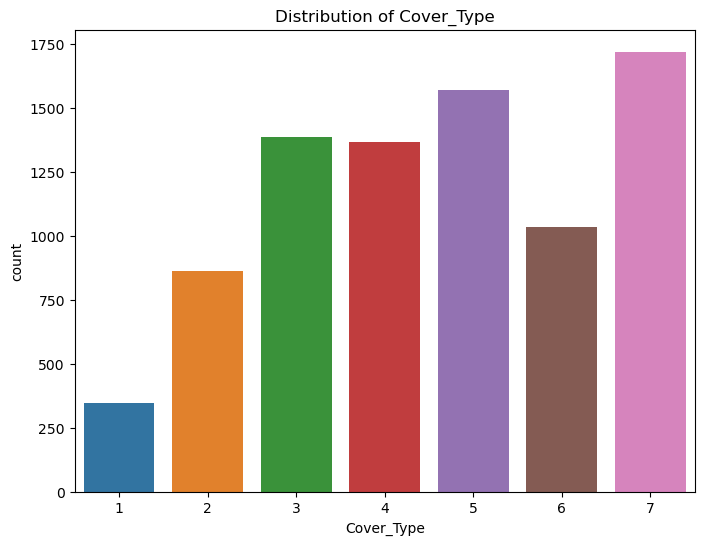

In [114]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Cover_Type', data=training_data)
plt.title('Distribution of Cover_Type')
plt.show()

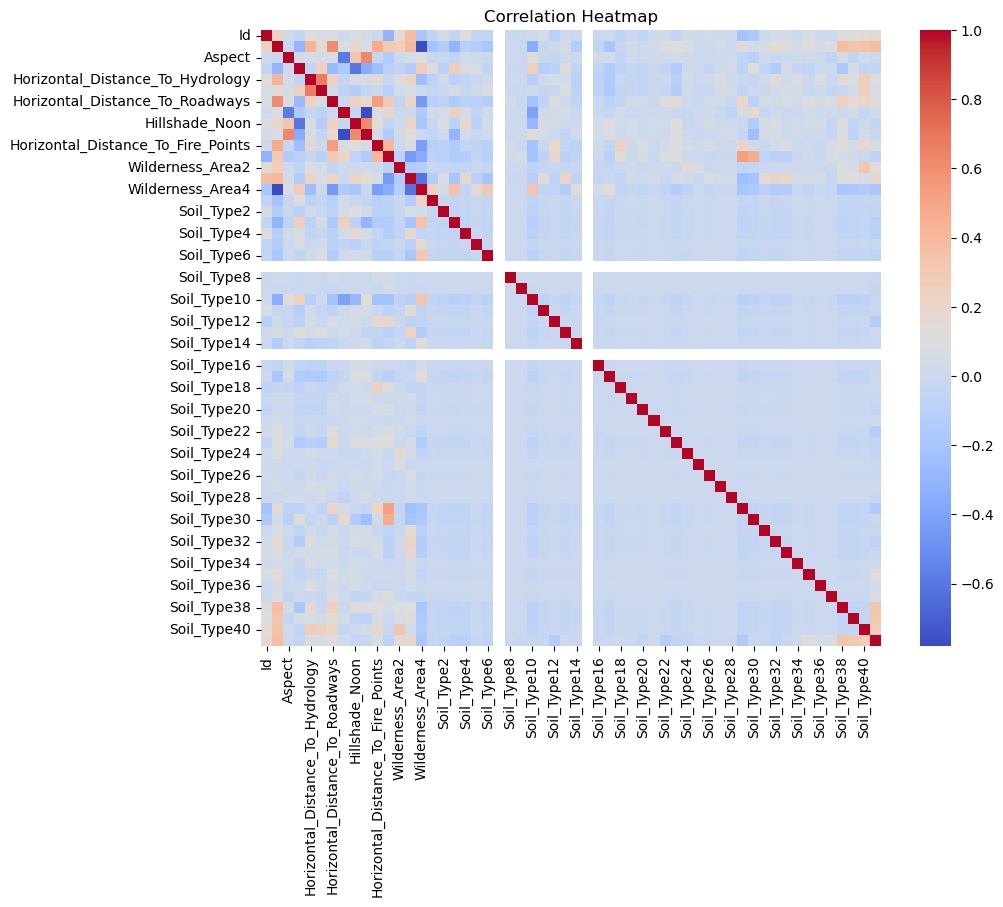

In [125]:
# Correlation heatmap
corr_matrix = training_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

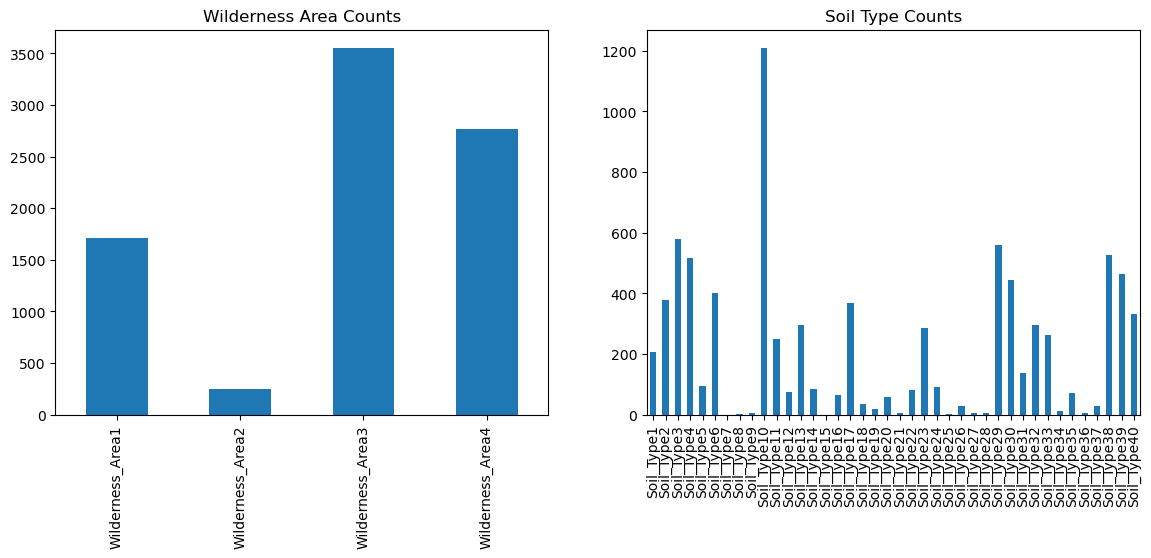

In [126]:
# Binary features analysis
wilderness_cols = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
soil_cols = training_data.columns[15:-1]

wilderness_counts = training_data[wilderness_cols].sum()
soil_counts = training_data[soil_cols].sum()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wilderness_counts.plot(kind='bar')
plt.title('Wilderness Area Counts')
plt.subplot(1, 2, 2)
soil_counts.plot(kind='bar', figsize=(14, 5))
plt.title('Soil Type Counts')
plt.show()

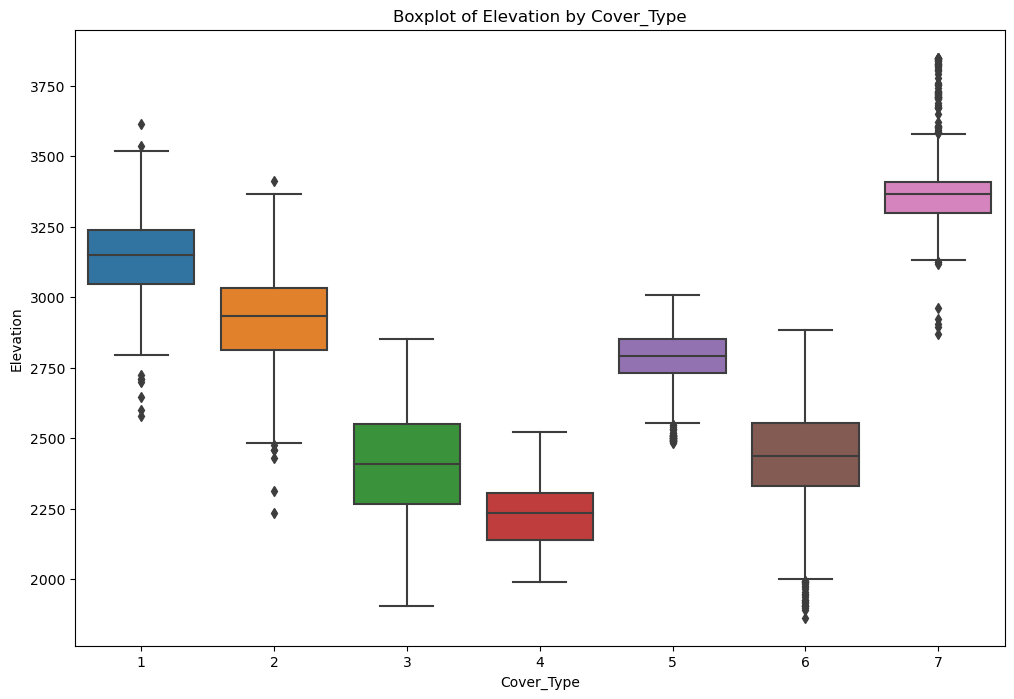

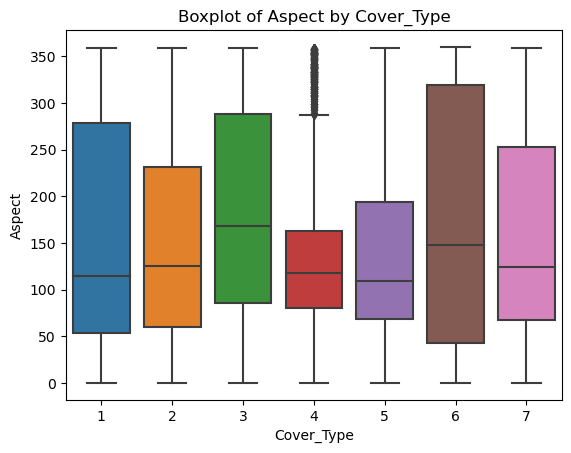

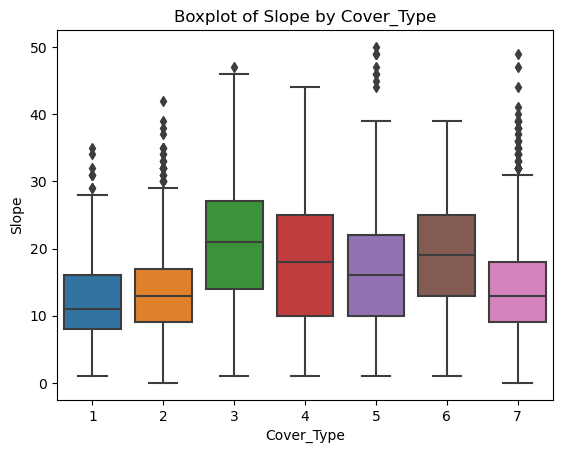

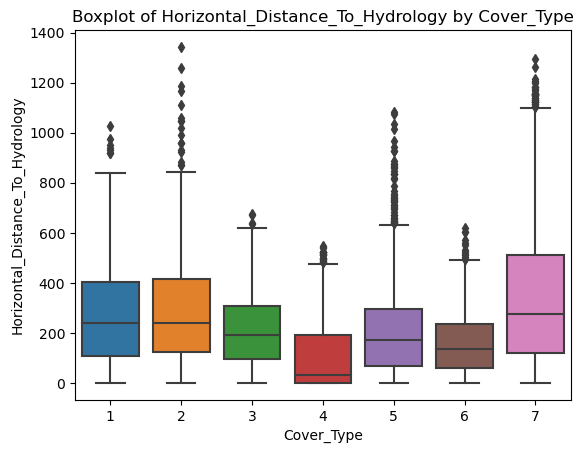

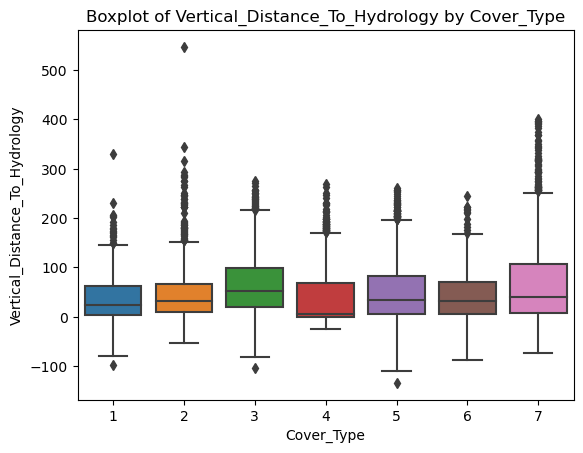

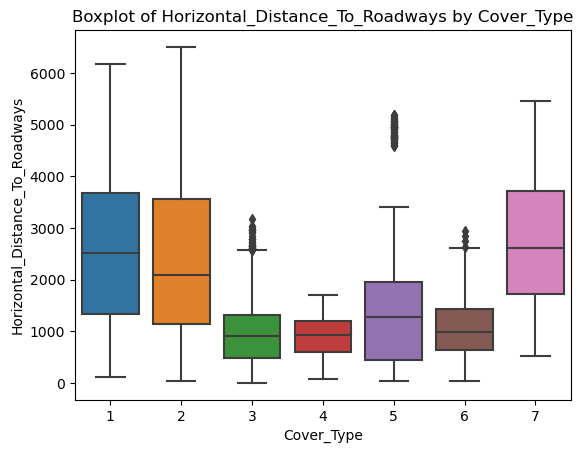

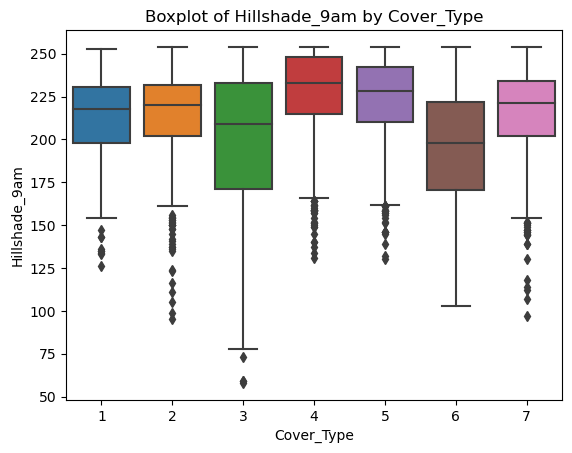

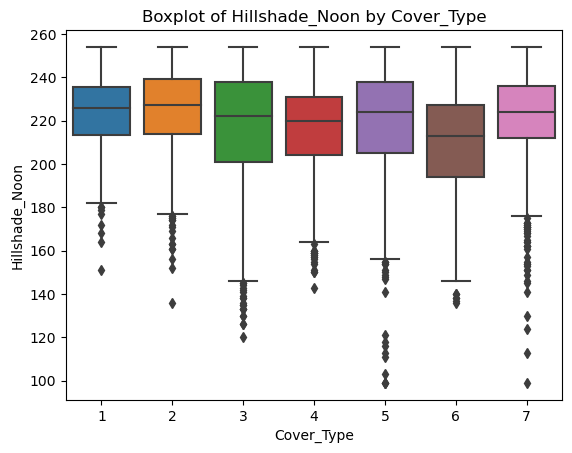

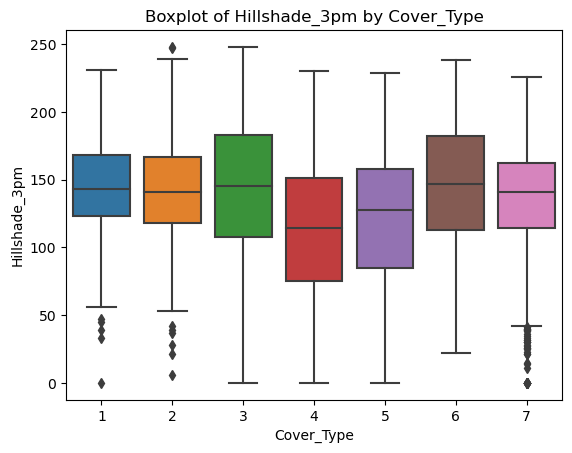

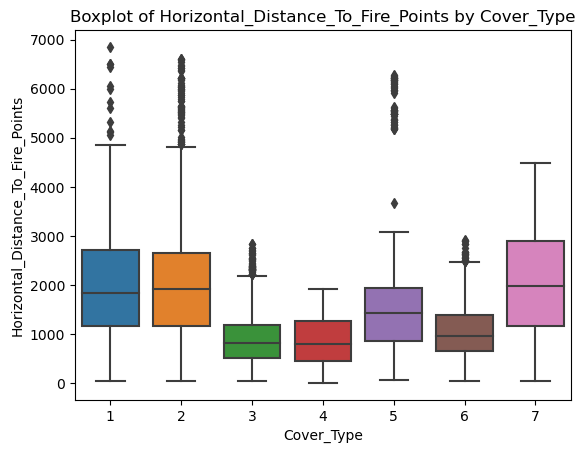

In [120]:
# Box plot of numerical features for each cover type
numerical_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                      'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                      'Horizontal_Distance_To_Fire_Points']

plt.figure(figsize=(12, 8))
for feature in numerical_features:
    sns.boxplot(x='Cover_Type', y=feature, data=training_data)
    plt.title(f'Boxplot of {feature} by Cover_Type')
    plt.show()


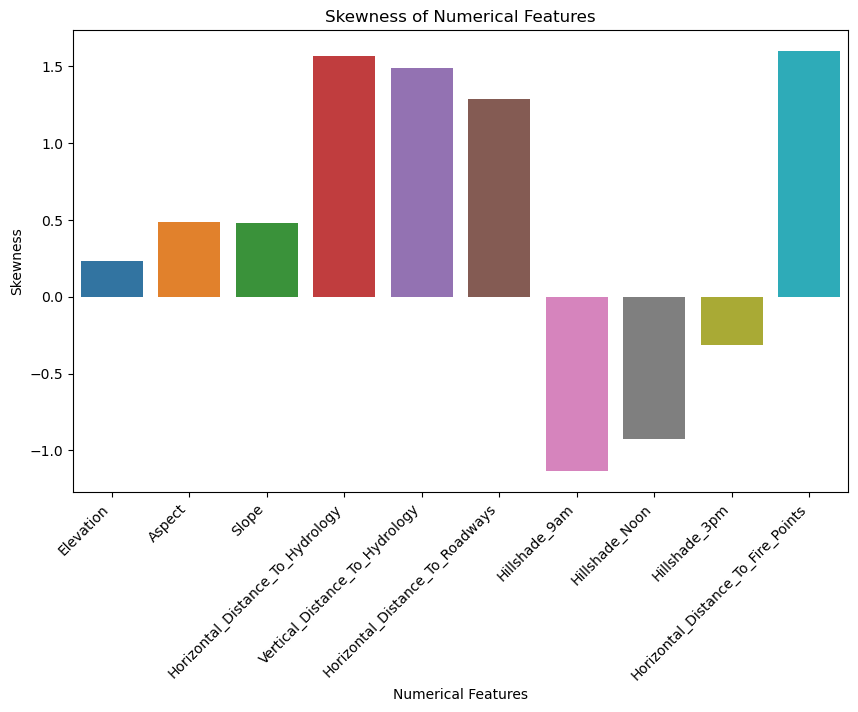

In [128]:
# Select numerical features for skewness analysis
numerical_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                      'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                      'Horizontal_Distance_To_Fire_Points']

# Calculate skewness for each numerical feature
skewness_values = training_data[numerical_features].skew()

# Bar plot of skewness values
plt.figure(figsize=(10, 6))
sns.barplot(x=skewness_values.index, y=skewness_values.values)
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.xlabel('Numerical Features')
plt.ylabel('Skewness')
plt.show()

/tmp/ipykernel_32/3699508414.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_32/3699508414.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_32/3699508414.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_32/3699508414.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_32/3699508414.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


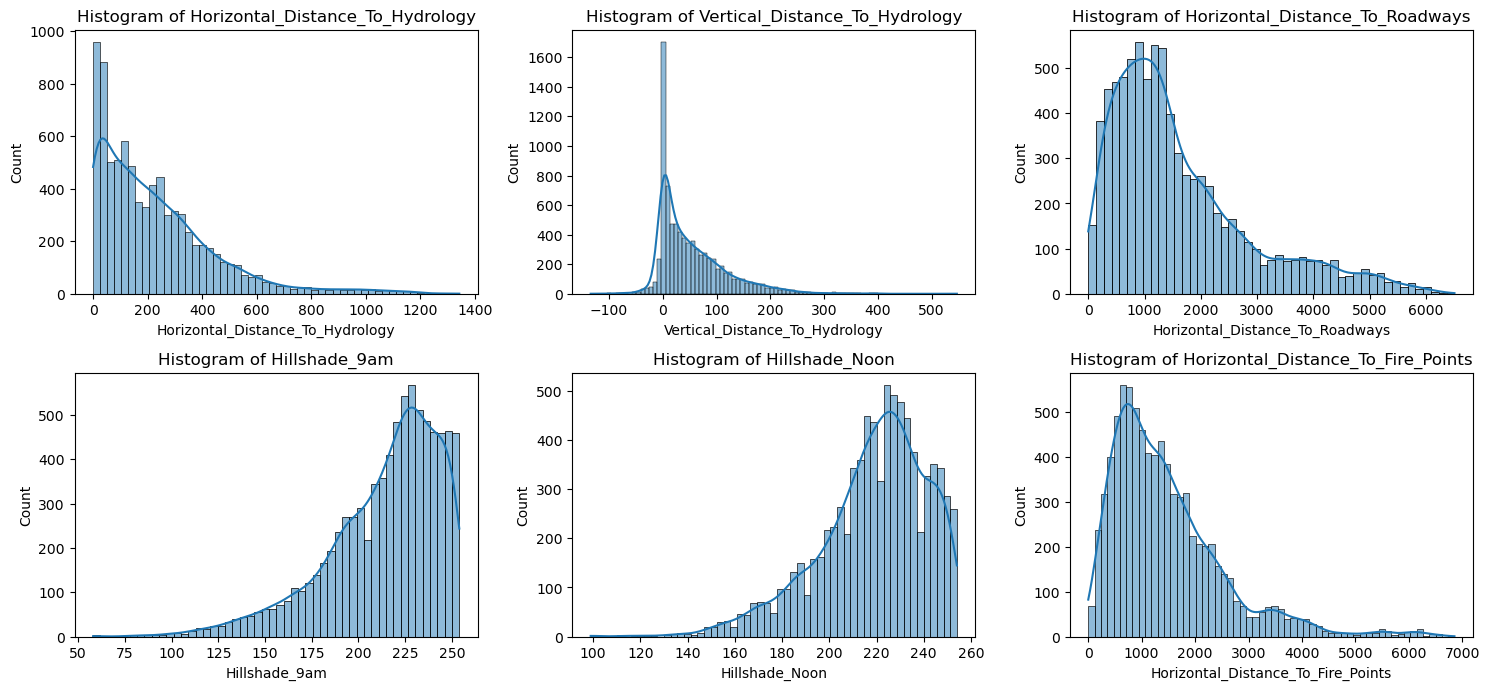

In [129]:
# Create histograms for skewed features
skewed_features = skewness_values[skewness_values.abs() > 0.5].index

plt.figure(figsize=(15, 10))
for i, feature in enumerate(skewed_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(training_data[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.tight_layout()
plt.show()

# Visualize the training and test set to understand problem nature

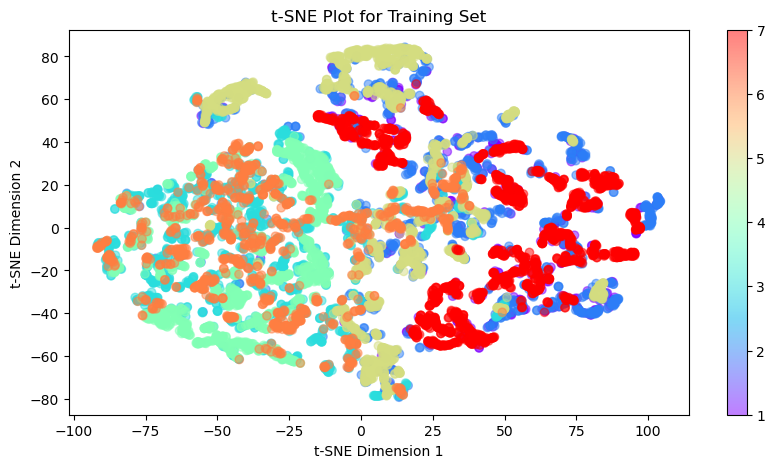

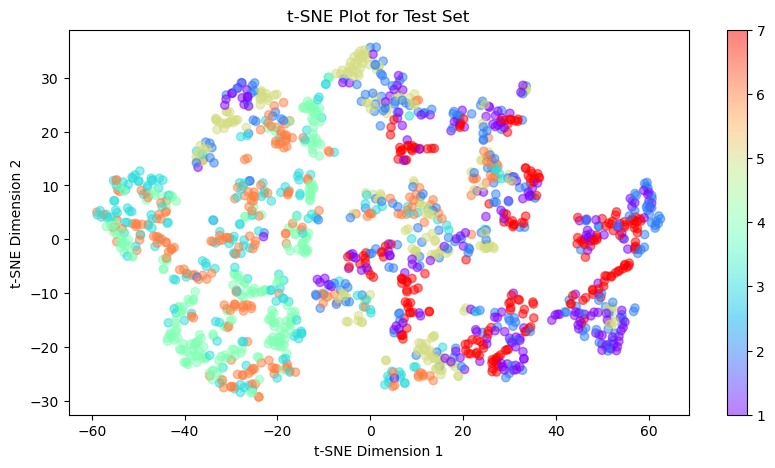

In [11]:
# Plot t-SNE for the training set
plot_tsne(training_data, 'Cover_Type', 't-SNE Plot for Training Set')

# Plot t-SNE for the test set
plot_tsne(test_data, 'Cover_Type', 't-SNE Plot for Test Set')

# Q1) Obtain a baseline performance

In [14]:
# Separate features (X) and target variable (y)
X_train = training_data.drop(columns=['Cover_Type', 'Id'])
y_train = training_data['Cover_Type']

X_valid = validation_data.drop(columns=['Cover_Type', 'Id'])
y_valid = validation_data['Cover_Type']

X_test = test_data.drop(columns=['Cover_Type', 'Id'])
y_test = test_data['Cover_Type']

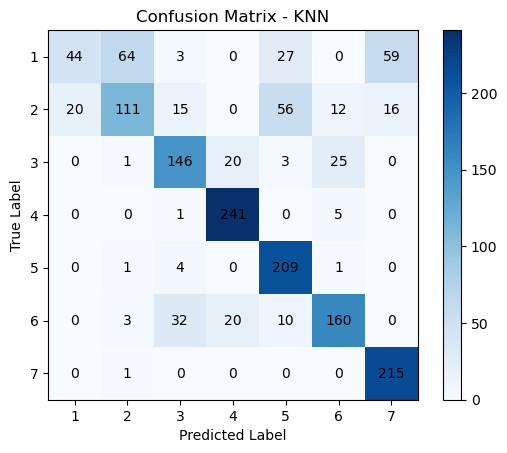

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


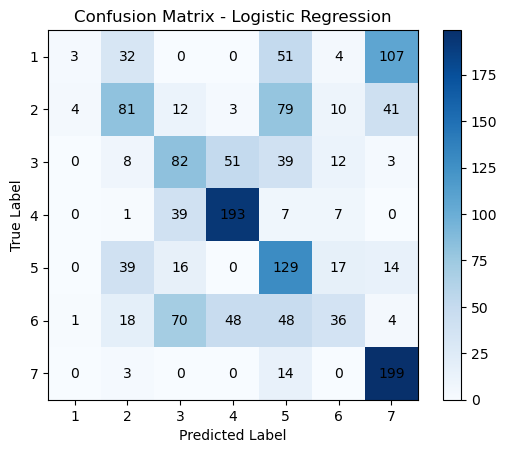

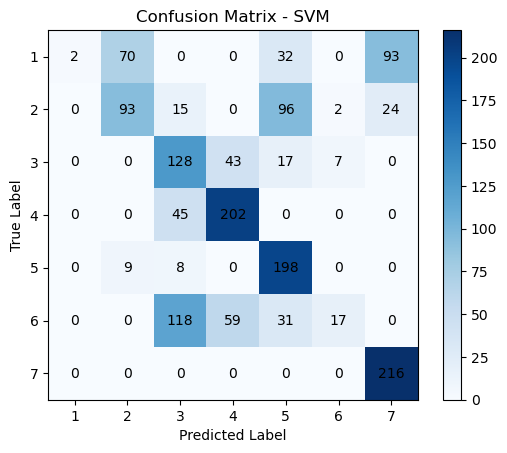

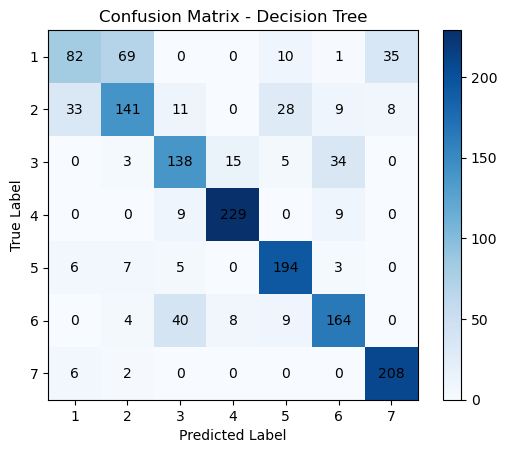

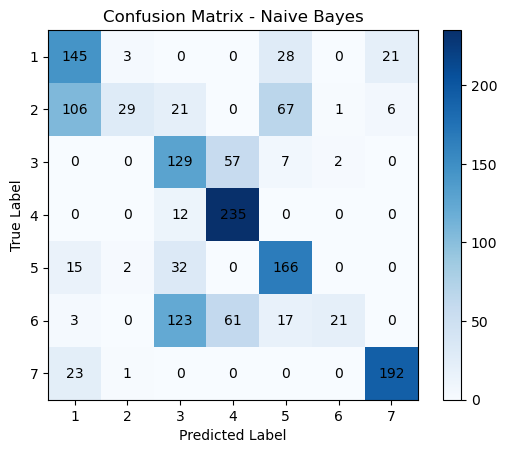

In [15]:
# Set the random state
random_state = 42

# Dictionary to store model names and their corresponding classifiers
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(random_state=random_state),
    "SVM": SVC(random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "Naive Bayes": GaussianNB()
}

# Dictionary to store model accuracies
accuracies = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    accuracies[model_name] = acc_test
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Plot the confusion matrix
    plot_confusion_matrix(cm, model_name)

In [16]:
# Tabulate the accuracies
tabulate_accuracies(accuracies)

Model                  Accuracy
-------------------  ----------
KNN                    0.738361
Logistic Regression    0.474098
SVM                    0.561311
Decision Tree          0.758033
Naive Bayes            0.601311


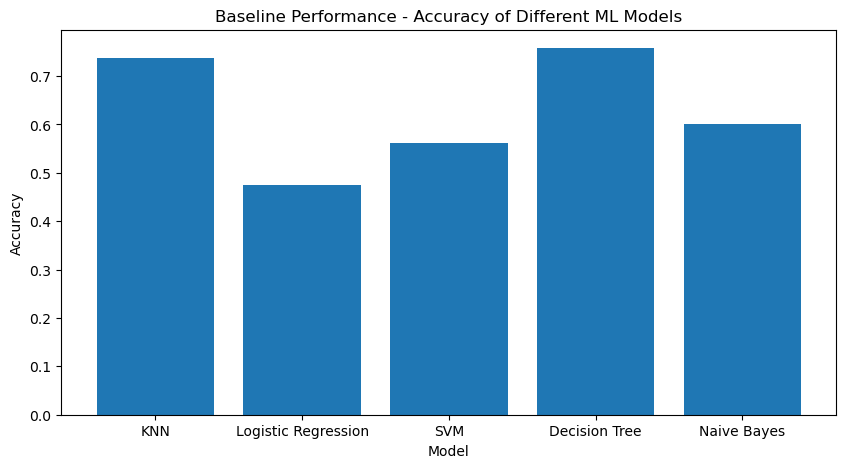

In [17]:
# Plot the accuracies
plot_accuracies(accuracies)

In [18]:
# Find the two best performing models (highest test accuracy)
best_models = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)[:2]
best_model1_name, best_model1_acc = best_models[0]
best_model2_name, best_model2_acc = best_models[1]

print(f"Best performing model 1: {best_model1_name}, Test Accuracy: {best_model1_acc:.4f}")
print(f"Best performing model 2: {best_model2_name}, Test Accuracy: {best_model2_acc:.4f}")

Best performing model 1: Decision Tree, Test Accuracy: 0.7580
Best performing model 2: KNN, Test Accuracy: 0.7384


#  Q2) First Improvement strategy : Comparing dimensionality reduction to feature selection

In [19]:
# Number of features to consider for feature selection
k_values = list(range(1, 16))

# Create Decision Tree and KNN models
dt_model = DecisionTreeClassifier(random_state=random_state)
knn_model = KNeighborsClassifier()

### Filter Method

In [20]:
# Evaluate Decision Tree and KNN models with different numbers of features
dt_accuracies, dt_selected_features = select_k_best_features(X_train, X_test, y_train, y_test, k_values, dt_model)
knn_accuracies, knn_selected_features = select_k_best_features(X_train, X_test, y_train, y_test, k_values, knn_model)

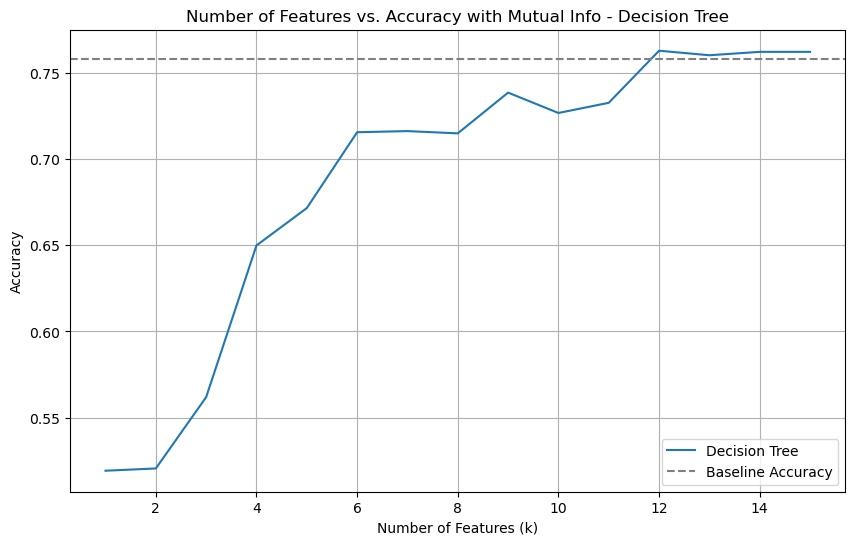

In [21]:
# Plot for Decision Tree
plot_accuracy_vs_features(k_values, dt_accuracies, best_model1_acc,"Mutual Info", "Decision Tree")


In [22]:
# Find the best accuracy and the corresponding k for Decision Tree
best_dt_k = max(dt_accuracies, key=dt_accuracies.get)
best_dt_accuracy = dt_accuracies[best_dt_k]

# Access the selected feature indices for the best Decision Tree model
best_dt_selected_features = dt_selected_features[best_dt_k]

print("Best Decision Tree Accuracy:")
print(f"Accuracy: {best_dt_accuracy:.4f}")
print(f"Number of Features (k): {best_dt_k}")
print(f"Selected features indices: {best_dt_selected_features}")


Best Decision Tree Accuracy:
Accuracy: 0.7626
Number of Features (k): 12
Selected features indices: [ 0 13  5  9 10 23 12 16  6 52 51  3]


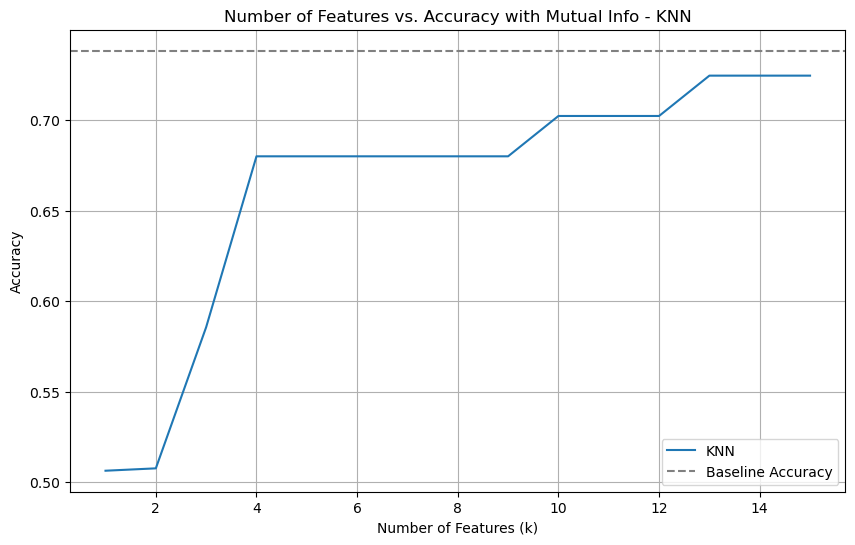

In [23]:
# Plot for KNN
plot_accuracy_vs_features(k_values, knn_accuracies, best_model2_acc,"Mutual Info", "KNN")

In [24]:
# Find the best accuracy and the corresponding k for KNN
best_knn_k = max(knn_accuracies, key=knn_accuracies.get)
best_knn_accuracy = knn_accuracies[best_knn_k]

# Access the selected feature indices for the best KNN model
best_knn_selected_features = knn_selected_features[best_knn_k]

print("\nBest KNN Accuracy:")
print(f"Accuracy: {best_knn_accuracy:.4f}")
print(f"Number of Features (k): {best_knn_k}")
print(f"Selected features indices: {best_knn_selected_features}")


Best KNN Accuracy:
Accuracy: 0.7246
Number of Features (k): 13
Selected features indices: [ 0 13  5  9 10 12 23 16 51  6 52 42  3]


### Wrapper Method

In [25]:
# Evaluate Decision Tree and KNN models with different numbers of features using SequentialFeatureSelector
dt_accuracies, dt_selected_features = forward_feature_selection(X_train, X_test, y_train, y_test, dt_model, k_values)
knn_accuracies, knn_selected_features = forward_feature_selection(X_train, X_test, y_train, y_test, knn_model, k_values)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


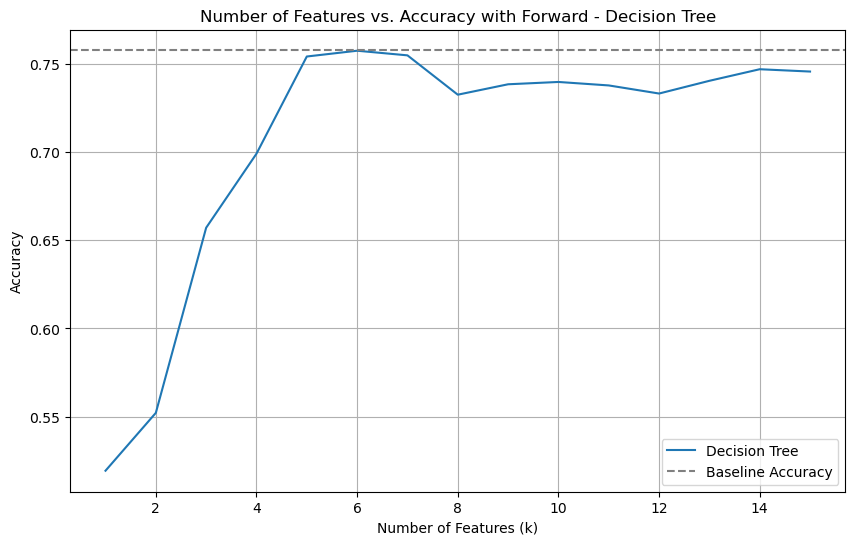

In [26]:
# Plot for Decision Tree
plot_accuracy_vs_features(k_values, dt_accuracies, best_model1_acc,"Forward", "Decision Tree")

In [30]:
# Find the best accuracy and the corresponding k for Decision Tree
best_dt_k2 = max(dt_accuracies, key=dt_accuracies.get)
best_dt_accuracy2 = dt_accuracies[best_dt_k]

# Access the selected feature indices for the best Decision Tree model
best_dt_selected_features2 = dt_selected_features[best_dt_k]

print("Best Decision Tree Accuracy:")
print(f"Accuracy: {best_dt_accuracy2:.4f}")
print(f"Number of Features (k): {best_dt_k2}")
print(f"Selected features indices: {best_dt_selected_features2}")

Best Decision Tree Accuracy:
Accuracy: 0.7331
Number of Features (k): 6
Selected features indices: [ 0  1  3  4  5  9 10 16 23 29 35 49]


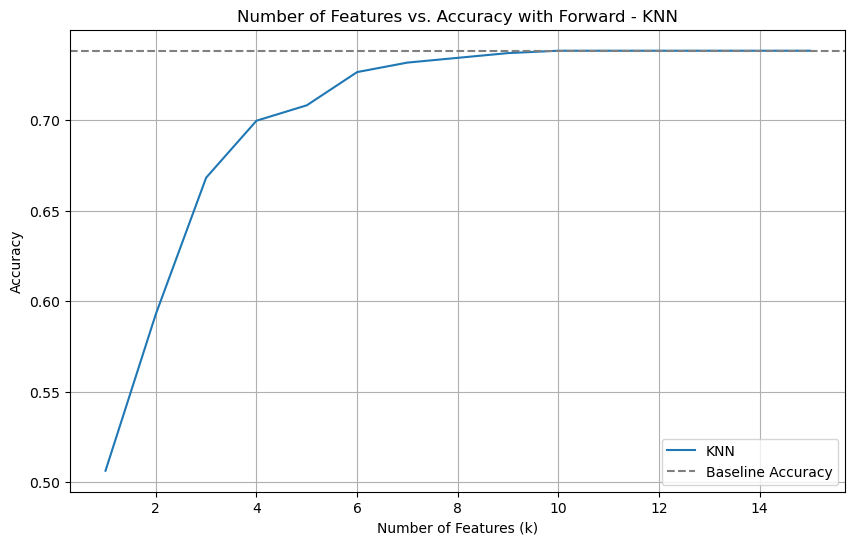

In [31]:
# Plot for KNN
plot_accuracy_vs_features(k_values, knn_accuracies, best_model2_acc,"Forward", "KNN")

In [32]:
# Find the best accuracy and the corresponding k for KNN
best_knn_k2 = max(knn_accuracies, key=knn_accuracies.get)
best_knn_accuracy2 = knn_accuracies[best_knn_k]

# Access the selected feature indices for the best KNN model
best_knn_selected_features2 = knn_selected_features[best_knn_k]

print("\nBest KNN Accuracy:")
print(f"Accuracy: {best_knn_accuracy2:.4f}")
print(f"Number of Features (k): {best_knn_k2}")
print(f"Selected features indices: {best_knn_selected_features2}")


Best KNN Accuracy:
Accuracy: 0.7384
Number of Features (k): 10
Selected features indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]


### PCA Method

In [33]:
# Apply PCA and evaluate Decision Tree and KNN models with different numbers of components
dt_accuracies, best_dt_num_components = apply_pca(X_train, X_test, k_values, dt_model)
knn_accuracies, best_knn_num_components = apply_pca(X_train, X_test, k_values, knn_model)

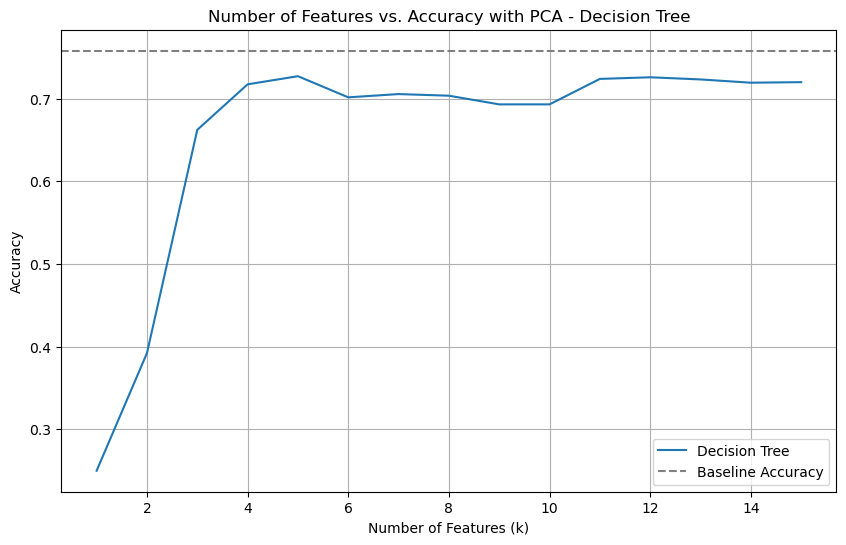

In [34]:
# Plot accuracy vs. number of components for Decision Tree and KNN
plot_accuracy_vs_features(k_values, dt_accuracies, best_model1_acc,"PCA", "Decision Tree")

In [35]:
print("Best Decision Tree Accuracy:")
print(f"Accuracy: {dt_accuracies[best_dt_num_components]:.4f}")
print(f"Number of Components: {best_dt_num_components}")

Best Decision Tree Accuracy:
Accuracy: 0.7272
Number of Components: 5


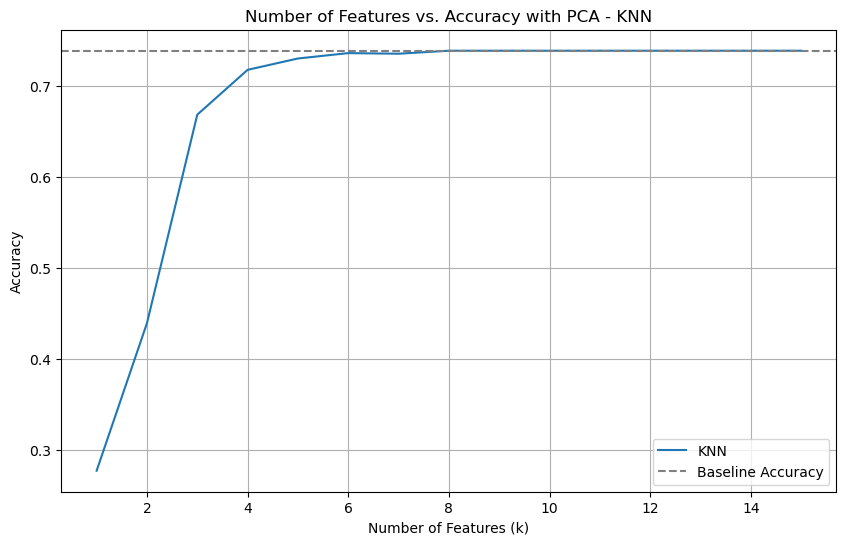

In [36]:
plot_accuracy_vs_features(k_values, knn_accuracies, best_model2_acc,"PCA", "KNN")

In [37]:
print("\nBest KNN Accuracy:")
print(f"Accuracy: {knn_accuracies[best_knn_num_components]:.4f}")
print(f"Number of Components: {best_knn_num_components}")


Best KNN Accuracy:
Accuracy: 0.7384
Number of Components: 8


# Q3) Adding more machine learning model

In [25]:
# Use the selected features for both Decision Tree and KNN
X_train_selected_dt = X_train.iloc[:, best_dt_selected_features]
X_valid_selected_dt = X_valid.iloc[:, best_dt_selected_features]
X_test_selected_dt = X_test.iloc[:, best_dt_selected_features]

### Baseline (Decision Tree with Filter Selection)

In [26]:
# Train and evaluate Decision Tree with the selected features as the baseline model
baseline_dt_model = DecisionTreeClassifier(random_state=random_state)
baseline_dt_model.fit(X_train_selected_dt, y_train)
y_pred_baseline = baseline_dt_model.predict(X_test_selected_dt)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print("Baseline (Decision Tree with Feature Selection) Accuracy:")
print(f"Accuracy: {baseline_accuracy:.4f}")

Baseline (Decision Tree with Feature Selection) Accuracy:
Accuracy: 0.7626


### Random Forest

In [27]:
# Train and evaluate Random Forest with the selected features
random_forest_model = RandomForestClassifier(random_state=random_state)
random_forest_model.fit(X_train_selected_dt, y_train)
y_pred_random_forest = random_forest_model.predict(X_test_selected_dt)
random_forest_accuracy = accuracy_score(y_test, y_pred_random_forest)

print("Random Forest Accuracy:")
print(f"Accuracy: {random_forest_accuracy:.4f}")


Random Forest Accuracy:
Accuracy: 0.8125


### Stacking ensemble 

In [28]:
# Create the Stacking ensemble model with Decision Tree, Random Forest, Bagging, and KNN
stacking_model = StackingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', random_forest_model),
    ('knn', knn_model)
])
# Train and evaluate the Stacking ensemble model with the selected features
stacking_model.fit(X_train_selected_dt, y_train)
y_pred_stacking = stacking_model.predict(X_test_selected_dt)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)

print("Stacking Ensemble Accuracy:")
print(f"Accuracy: {stacking_accuracy:.4f}")

Stacking Ensemble Accuracy:
Accuracy: 0.8328


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Voting ensemble

In [29]:
# Create the Voting ensemble model with Decision Tree, Random Forest, and KNN
voting_model = VotingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', random_forest_model),
    ('knn', knn_model)
])

# Train and evaluate the Voting ensemble model with the selected features
voting_model.fit(X_train_selected_dt, y_train)
y_pred_voting = voting_model.predict(X_test_selected_dt)
voting_accuracy = accuracy_score(y_test, y_pred_voting)

print("Voting Ensemble Accuracy:")
print(f"Accuracy: {voting_accuracy:.4f}")

Voting Ensemble Accuracy:
Accuracy: 0.8020


### Results

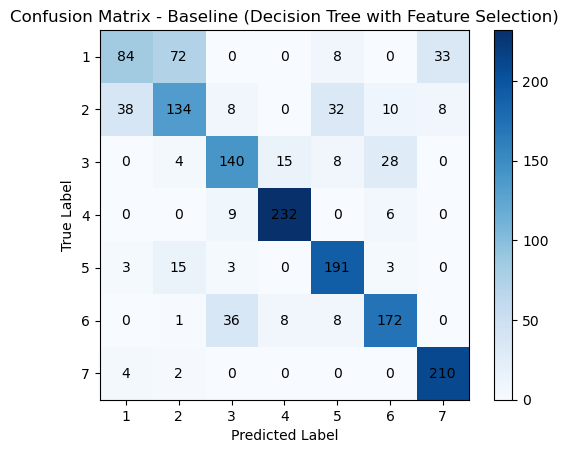

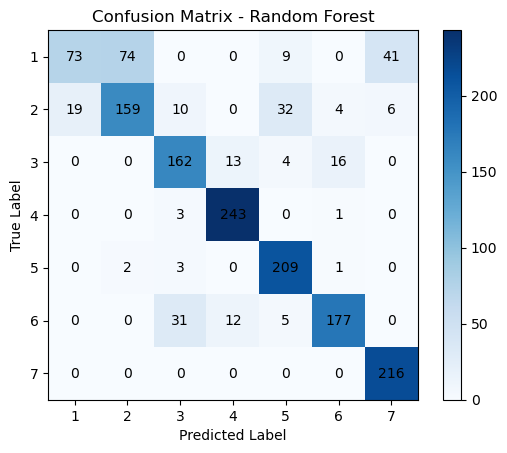

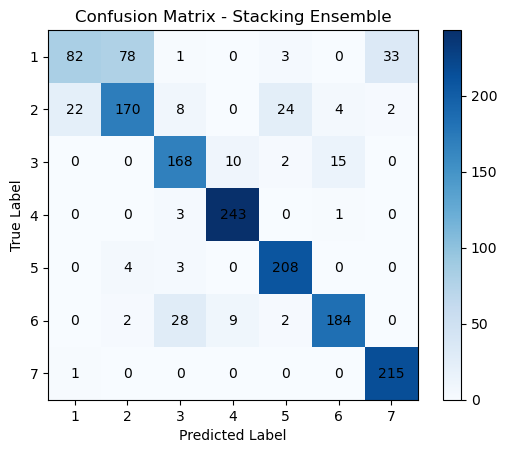

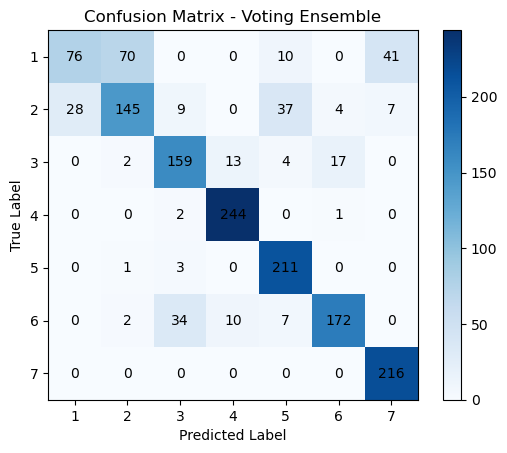

In [30]:
# Calculate confusion matrices for all models
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_rf = confusion_matrix(y_test, y_pred_random_forest)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
cm_voting = confusion_matrix(y_test, y_pred_voting)


# Plot confusion matrices
plot_confusion_matrix(cm_baseline, "Baseline (Decision Tree with Feature Selection)")
plot_confusion_matrix(cm_rf, "Random Forest")
plot_confusion_matrix(cm_stacking, "Stacking Ensemble")
plot_confusion_matrix(cm_voting, "Voting Ensemble")

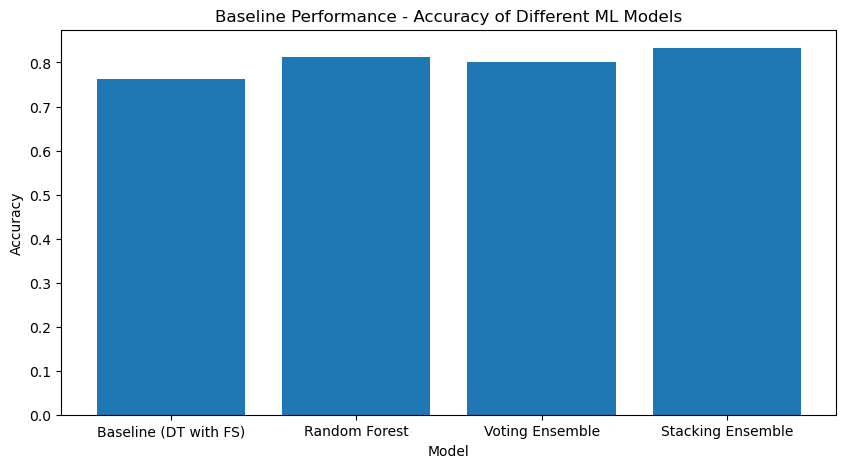

In [31]:
# Dictionary to store model accuracies
accuracies = {
    "Baseline (DT with FS)": baseline_accuracy,
    "Random Forest": random_forest_accuracy,
    "Voting Ensemble": voting_accuracy,
    "Stacking Ensemble": stacking_accuracy
}

# Plot the accuracies of different ML models
plot_accuracies(accuracies)

# Q4) Supervised & Unsupervised Combination via PKI

### Supervied Model

##### Training

In [32]:
# Create the Stacking ensemble model with Decision Tree, Random Forest, Bagging, and KNN
stacking_model_train = StackingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', random_forest_model),
    ('knn', knn_model)
])
# Train and evaluate the Stacking ensemble model with the selected features
stacking_model_train.fit(X_train_selected_dt, y_train)
Y_out_train = stacking_model_train.predict(X_train_selected_dt)
stacking_accuracy_train = accuracy_score(y_train, Y_out_train)

print("Stacking Ensemble Accuracy:")
print(f"Accuracy: {stacking_accuracy_train:.4f}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Ensemble Accuracy:
Accuracy: 0.9994


##### Validate

In [33]:
# Create the Stacking ensemble model with Decision Tree, Random Forest, Bagging, and KNN
stacking_model_valid = StackingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', random_forest_model),
    ('knn', knn_model)
])
# Train and evaluate the Stacking ensemble model with the selected features
stacking_model_valid.fit(X_valid_selected_dt, y_valid)
Y_out_valid = stacking_model_valid.predict(X_valid_selected_dt)
stacking_accuracy_valid = accuracy_score(y_valid, Y_out_valid)

print("Stacking Ensemble Accuracy:")
print(f"Accuracy: {stacking_accuracy_valid:.4f}")

Stacking Ensemble Accuracy:
Accuracy: 0.9993


##### Test

In [103]:
# Create the Stacking ensemble model with Decision Tree, Random Forest, Bagging, and KNN
stacking_model_test = StackingClassifier(estimators=[
    ('decision_tree', dt_model),
    ('random_forest', random_forest_model),
    ('knn', knn_model)
])
# Train and evaluate the Stacking ensemble model with the selected features
stacking_model_test.fit(X_train_selected_dt, y_train)
Y_out_test = stacking_model_test.predict(X_test_selected_dt)
stacking_accuracy_test = accuracy_score(y_test, Y_out_test)

print("Stacking Ensemble Accuracy:")
print(f"Accuracy: {stacking_accuracy_test:.4f}")

Stacking Ensemble Accuracy:
Accuracy: 0.8328


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Unsupervied Model

##### Training

In [96]:
# Grid sizes to loop through
grid_sizes = [(6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12)]

accuracies = []

# Loop through different grid sizes
for grid_size in grid_sizes:
    num_epochs = 1000  # Number of epochs for MiniSom training
    input_shape = X_train_selected_dt.shape[1]  # Input shape of the data

    # Train MiniSom and get cluster labels
    Y_cluster_train = train_mini_som_and_get_clusters(grid_size, input_shape, X_train_selected_dt)
    Y_cluster_valid = train_mini_som_and_get_clusters(grid_size, input_shape, X_valid_selected_dt)
    Y_cluster_test = train_mini_som_and_get_clusters(grid_size, input_shape, X_test_selected_dt)
    
    ####
    Y_cluster_train = usLabels2sLabels(Y_cluster_train, y_train)
    Y_cluster_valid = usLabels2sLabels(Y_cluster_valid, y_valid)
    Y_cluster_test = usLabels2sLabels(Y_cluster_test, y_test)

    # Prepare PKI model input data and output labels
    X_pki_train = pd.DataFrame({'Y_cluster_train': Y_cluster_train, 'Y_out_train': Y_out_train})
    Y_pki_train = y_train
    
    X_pki_valid = pd.DataFrame({'Y_cluster_valid': Y_cluster_valid, 'Y_out_valid': Y_out_valid})
    Y_pki_valid = y_valid
    
    X_pki_test = pd.DataFrame({'Y_cluster_test': Y_cluster_test, 'Y_out_test': Y_out_test})
    Y_pki_test = y_test

    # Train PKI model and get accuracy for validation data
    accuracy = create_pki_model_and_train(X_pki_train, Y_pki_train, X_pki_test, Y_pki_test, X_pki_valid, Y_pki_valid, 4, 30)
    accuracies.append(accuracy)

Epoch 1/100
259/259 [==============================] - 2s 3ms/step - loss: 1.0262 - accuracy: 0.6635 - val_loss: 0.8250 - val_accuracy: 0.6856
Epoch 2/100
259/259 [==============================] - 1s 2ms/step - loss: 0.2744 - accuracy: 0.9475 - val_loss: 0.4335 - val_accuracy: 0.8371
Epoch 3/100
259/259 [==============================] - 1s 2ms/step - loss: 0.1087 - accuracy: 0.9855 - val_loss: 0.1559 - val_accuracy: 0.9713
Epoch 4/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0455 - accuracy: 0.9975 - val_loss: 0.0587 - val_accuracy: 0.9993
Epoch 5/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0251 - accuracy: 0.9994 - val_loss: 0.0340 - val_accuracy: 0.9993
Epoch 6/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0172 - accuracy: 0.9994 - val_loss: 0.0228 - val_accuracy: 0.9993
Epoch 7/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0136 - accuracy: 0.9994 - val_loss: 0.0164 - val_accuracy: 0.9993

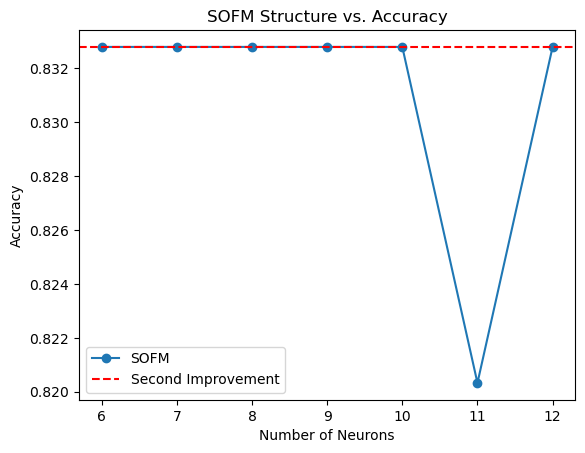

In [97]:
# Plot number of neurons vs. accuracy
neurons = [6,7,8,9,10,11,12]
plt.plot(neurons, accuracies, marker='o', linestyle='-', label=f'SOFM')
plt.axhline(y=stacking_accuracy_test, color='red', linestyle='--', label='Second Improvement')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('SOFM Structure vs. Accuracy')
plt.legend()
plt.show()

In [98]:
accuracies

[0.8327868580818176,
 0.8327868580818176,
 0.8327868580818176,
 0.8327868580818176,
 0.8327868580818176,
 0.820327877998352,
 0.8327868580818176]

##### Best PKI

In [99]:
# Train MiniSom and get cluster labels
Y_cluster_train = train_mini_som_and_get_clusters((6, 6), input_shape, X_train_selected_dt)
Y_cluster_valid = train_mini_som_and_get_clusters((6, 6), input_shape, X_valid_selected_dt)
Y_cluster_test = train_mini_som_and_get_clusters((6, 6), input_shape, X_test_selected_dt)

####
Y_cluster_train = usLabels2sLabels(Y_cluster_train, y_train)
Y_cluster_valid = usLabels2sLabels(Y_cluster_valid, y_valid)
Y_cluster_test = usLabels2sLabels(Y_cluster_test, y_test)

# Prepare PKI model input data and output labels
X_pki_train = pd.DataFrame({'Y_cluster_train': Y_cluster_train, 'Y_out_train': Y_out_train})
Y_pki_train = y_train

X_pki_valid = pd.DataFrame({'Y_cluster_valid': Y_cluster_valid, 'Y_out_valid': Y_out_valid})
Y_pki_valid = y_valid

X_pki_test = pd.DataFrame({'Y_cluster_test': Y_cluster_test, 'Y_out_test': Y_out_test})
Y_pki_test = y_test

# Train PKI model and get predictions for validation data
PKI_accuracy = create_pki_model_and_train(X_pki_train, Y_pki_train, X_pki_test, Y_pki_test, X_pki_valid, Y_pki_valid, 4, 30)

Epoch 1/100
259/259 [==============================] - 2s 3ms/step - loss: 1.0235 - accuracy: 0.6615 - val_loss: 0.8548 - val_accuracy: 0.6395
Epoch 2/100
259/259 [==============================] - 1s 2ms/step - loss: 0.2670 - accuracy: 0.9357 - val_loss: 0.3654 - val_accuracy: 0.8518
Epoch 3/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0967 - accuracy: 0.9864 - val_loss: 0.1693 - val_accuracy: 0.9166
Epoch 4/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0415 - accuracy: 0.9982 - val_loss: 0.0706 - val_accuracy: 0.9973
Epoch 5/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0236 - accuracy: 0.9989 - val_loss: 0.0407 - val_accuracy: 0.9993
Epoch 6/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0166 - accuracy: 0.9994 - val_loss: 0.0261 - val_accuracy: 0.9993
Epoch 7/100
259/259 [==============================] - 1s 2ms/step - loss: 0.0132 - accuracy: 0.9994 - val_loss: 0.0200 - val_accuracy: 0.9993

In [102]:
PKI_accuracy

0.8327868580818176

# Q5) Applying parameter fine tuning to get better performance from theprevious best performance

In [104]:
# Lists to store results
num_hidden_layers_list = [1, 2, 3, 5]  # Updated list without 4 layers
num_neurons_list = [10, 20, 30, 40, 50]  # Try different numbers of neurons in each layer
accuracies = []

# Grid search loop
for num_hidden_layers in num_hidden_layers_list:
    for num_neurons in num_neurons_list:
        PKI_accuracy = create_pki_model_and_train(X_pki_train, Y_pki_train, X_pki_test, Y_pki_test, X_pki_valid, Y_pki_valid, num_hidden_layers, num_neurons)
        print(f"Num Hidden Layers: {num_hidden_layers}, Num Neurons: {num_neurons}, Accuracy: {PKI_accuracy}")
        accuracies.append(PKI_accuracy)


Epoch 1/100
259/259 [==============================] - 1s 3ms/step - loss: 1.8078 - accuracy: 0.2755 - val_loss: 1.6597 - val_accuracy: 0.1849
Epoch 2/100
259/259 [==============================] - 1s 2ms/step - loss: 1.4402 - accuracy: 0.3618 - val_loss: 1.5479 - val_accuracy: 0.2730
Epoch 3/100
259/259 [==============================] - 1s 2ms/step - loss: 1.2996 - accuracy: 0.5626 - val_loss: 1.4496 - val_accuracy: 0.4446
Epoch 4/100
259/259 [==============================] - 1s 2ms/step - loss: 1.1765 - accuracy: 0.6388 - val_loss: 1.3617 - val_accuracy: 0.4446
Epoch 5/100
259/259 [==============================] - 1s 2ms/step - loss: 1.0692 - accuracy: 0.6698 - val_loss: 1.2870 - val_accuracy: 0.5287
Epoch 6/100
259/259 [==============================] - 1s 2ms/step - loss: 0.9741 - accuracy: 0.7268 - val_loss: 1.2098 - val_accuracy: 0.5421
Epoch 7/100
259/259 [==============================] - 1s 2ms/step - loss: 0.8901 - accuracy: 0.7427 - val_loss: 1.1422 - val_accuracy: 0.5581

In [105]:
# Find the best configuration
best_accuracy = max(accuracies)
best_config_index = accuracies.index(best_accuracy)
best_num_hidden_layers = num_hidden_layers_list[best_config_index]
best_num_neurons = num_neurons_list[best_config_index]

print("Best Configuration:")
print(f"Num Hidden Layers: {best_num_hidden_layers}, Num Neurons: {best_num_neurons}, Accuracy: {best_accuracy}")

Best Configuration:
Num Hidden Layers: 1, Num Neurons: 10, Accuracy: 0.8327868580818176


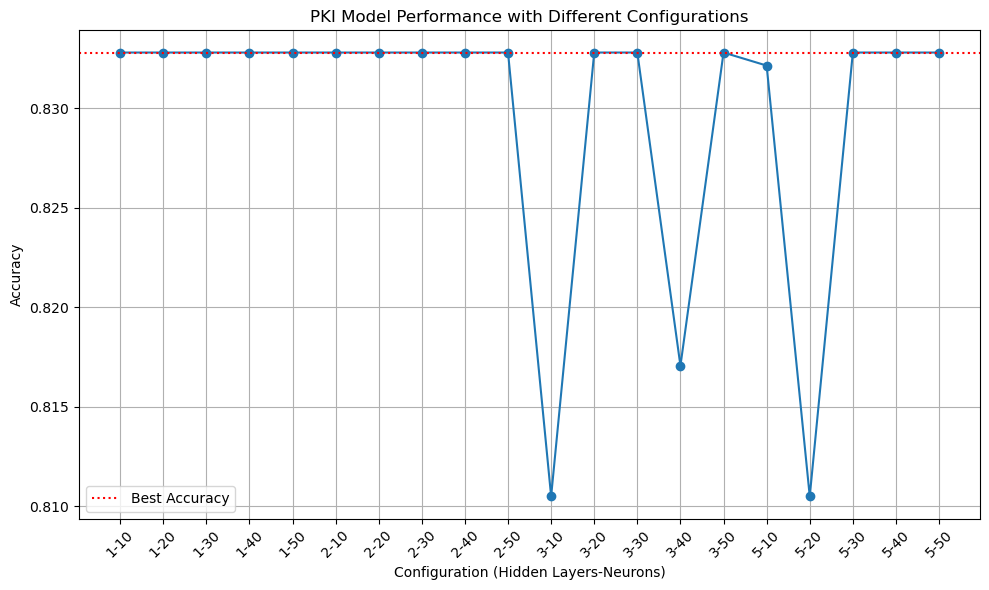

In [107]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(accuracies, marker='o')
plt.axhline(y=stacking_accuracy_test, color='r', linestyle='dotted', label='Best Accuracy')
plt.xticks(range(len(accuracies)), [f"{num_hidden_layers}-{num_neurons}" for num_hidden_layers in num_hidden_layers_list for num_neurons in num_neurons_list], rotation=45)
plt.xlabel('Configuration (Hidden Layers-Neurons)')
plt.ylabel('Accuracy')
plt.title('PKI Model Performance with Different Configurations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()